In [1]:
"""Notebook following Desponds et al's autocorrelation inference procedure on their data as a positive control"""

"Notebook following Desponds et al's autocorrelation inference procedure on their data as a positive control"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gfp_signal
from telegraph import exponential

In [3]:
from astropy.table import Table

In [4]:
import csv
import os

In [5]:
# helpful function for cutting the autocorrelation function into two parts (only want righthand side decay shape)
def findMiddleIndex(input_list):
    middle = float(len(input_list))/2
    if middle % 2 != 0:
        return int(middle - .5)
    else:
        return (int(middle))

In [6]:
# take in anterior cell cycle 13 data ... Pon should be about 0.45
table = Table.read('desponds_data/embryo3-anterior-nc13.csv')

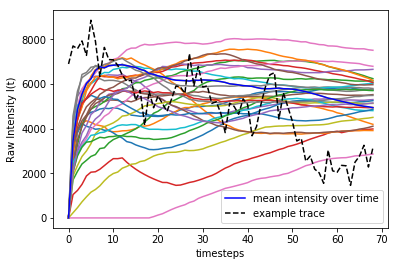

In [7]:
# take a look at the average intensities over time to define a good "steady-state" window
for name in table.colnames:
    N = 0
    mean = []
    for j in range(len(table[name])):
        N+=1
        mean.append(np.sum(table[name][:j]) / N)
   
    plt.plot(mean)
    
plt.plot(mean, color='blue', label = "mean intensity over time")
plt.plot(table[name], '--', color='k', label='example trace')
plt.xlabel('timesteps')
plt.ylabel('Raw Intensity I(t)')
plt.legend()
    #plt.plot(t[name])

In [8]:
a = np.arange(5)
a*5
a = np.arange(len(traces)) * 6
len(np.mean(traces, axis=1))

NameError: name 'traces' is not defined

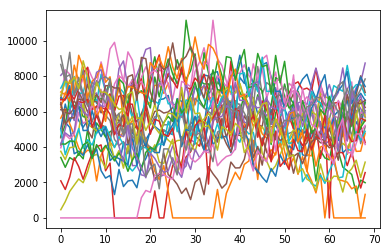

In [122]:
for name in table.colnames:
    plt.plot(table[name])

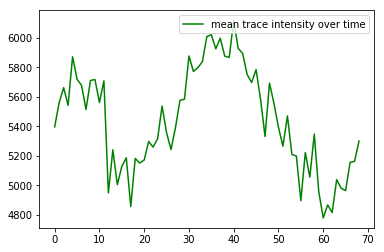

In [121]:
# plot mean intensity over time to define good steady-state window for embryo trace package
traces=[]
for name in table.colnames:
    trace = table[name]
    traces.append(trace)
    
seconds = np.arange(len(trace)) * 6

plt.plot(np.mean(traces, axis=0), color='green', label="mean trace intensity over time")
plt.legend()

In [10]:
# hard-code the autocorrelation of the signal from eq. (12) in Desponds et al
def autocorrelateSignal(trace):
    # over time-delay r
    auto_fn = []
    for r in range(len(trace)):
        sm1 = 0
        for i in range(len(trace)):
            for j in range(len(trace)):
                sm1 += trace[i]*trace[j]
        sm2 = 0.
        for k in range(len(trace)):
            #print(type(k))
            sm2 += (k^2)
        
        norm = ((len(trace)-float(r)) / len(trace)) * sm2
        auto_fn.append(sm1 / norm)
        return np.asarray(auto_fn)

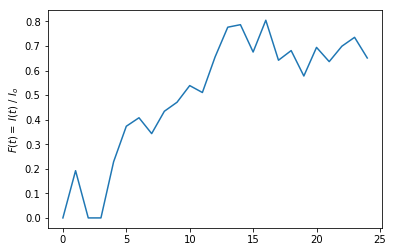

In [82]:
# compute autocorrelation with long time traces
autolist = []
tracelist = []
max_intens = []

steadystate_start_indx = 20
stop_indx = 45

for j in table.colnames:
# calibrate fluorescence signal: F(t) = I(t) / Io
    max_intens.append(np.max(table[j][steadystate_start_indx:stop_indx])) # get maximum fluorescence from each trace in given region
        
        # DO WE STILL COUNT ZERO SIGNAL CELLS????  --> yes, in fact, since they contribute to the average gene expression
        # for a given region.
    
I_o = np.mean(np.asarray(max_intens))   # mean of the maxima of all traces in set
#print('Io = ', I_o)

for name in table.colnames:
    trace = table[name][steadystate_start_indx:stop_indx]
    
    colsum = np.sum(trace)    
    if (colsum == 0):                                      # don't plot the zero signal traces
        auto_norm = np.ones(len(trace)) * np.nan         # set zero signal cells to nan to be ignored
        #corrected_trace = np.ones(len(t[name])) * np.nan
        
    else: 
        # calibrate fluorescence signal: F(t) = I(t) / Io        
        calibrated_trace = trace / I_o   
        
        # subtract out mean signal of each trace to prevent nucleus-nucleus variability
        corrected_trace = calibrated_trace - np.nanmean(calibrated_trace)
        
        auto = np.correlate(corrected_trace, corrected_trace, 'full')
        #auto = autocorrelateSignal(corrected_trace)
        auto = auto[np.argmax(auto):]     # take half of the autocorrelation function
        
        # finally, normalize        
        #auto_norm = auto / auto[0]
        for r in range(len(trace)):
            norm = []
            sm2 = 0.
            for k in range(len(trace)):
                sm2 += (k^2)
            norm.append(((len(trace)-float(r)) / len(trace)) * sm2)
            
        auto_norm = auto #/ (np.asarray(norm))
        
    autolist.append(auto_norm / auto_norm[0])
    tracelist.append(calibrated_trace)
    
plt.plot(tracelist[3])
    
plt.ylabel(r'$F(t) =$ $I(t)$ / $I_o$')
plt.show()

In [83]:
autolist;

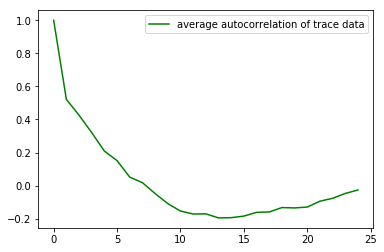

25


In [84]:
autoarr = np.asarray(autolist)

autoav = np.nanmean(autoarr, axis=0)
autocov = np.nanvar(autoarr, axis=0)
plt.plot(autoav, color = 'g', label = "average autocorrelation of trace data")
plt.legend(loc='best')
plt.show()

print(len(autoav))

In [85]:
# STEP TWO: Fit for value of Pon

In [112]:
# load in Desponds et al's loop function
import scipy.io as spio

loopFn = spio.loadmat('standalone/therightL.mat')

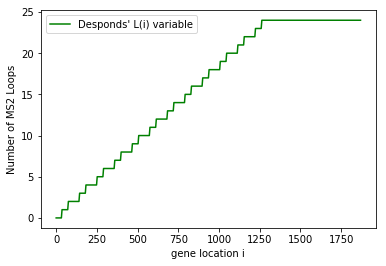

In [113]:
"""Parameters for Li model
ms: variable describing the number of binding sites on nascent mRNA
    ms[i] is the exact number of binding sites available when polII is 
    at the exact location i along the gene
Li: the number of binding sites on nascent mRNA given a BINNED position of polII i along gene"""
obs_time = 6  # seconds
tPol=6;       # RNAP loading time, corresponds to 1 polII every observation
ke=25;        # Elongation rate
sizePol = tPol * ke
variable = loopFn['ms']
ms = variable[0] 

plt.plot(ms, color='green', label = 'Desponds\' L(i) variable')
plt.xlabel('gene location i')
plt.ylabel('Number of MS2 Loops')
plt.legend(loc='best')

In [117]:
"""Now, compute the binned loop Li function"""
Li_fn = []
for i in range(len(ms)//sizePol):    
    Li_fn.append(np.sum(ms[(sizePol*(i-1)+1) : (sizePol*i)]) / sizePol)
    
#for i in range(len(loopfn)//sizePol):
if (i < len(ms) // sizePol):
    print(i)
    Li_fn[i] = np.sum(ms[(sizePol*(i)+1):-1]) / sizePol

11


In [118]:
np.sum(Li_fn) / 150

1.1357777777777778

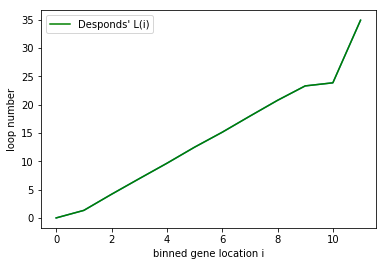

In [119]:
plt.plot(np.asarray(Li_fn))
plt.plot(Li_fn, label = 'Desponds\' L(i)', color='g')
plt.xlabel('binned gene location i')
plt.ylabel('loop number')
plt.legend(loc='best')

In [91]:
np.sum(Li_fn) / 160

1.0647916666666668

In [92]:
""" create the array of MS2 loops, L, as a function of position, i
    ***NOTE*** in Desponds et al: "Li" ~should really be written L(i) 
    (adapted from Desponds et al Matlab code) """
import scipy.io as spio
def loopfn(despondsfile, tPol, k_elong, sizePol):
    # load in Desponds et al's loop function
    loopFn = spio.loadmat(despondsfile)
    
    ms = loopFn['ms']
    ms = ms[0]              # stupid matLab puts an array inside an array
    
    
    # make the L(i) function (array of values)
    Li_fn = []
    for i in range(len(ms)//sizePol):    
        Li_fn.append(np.sum(ms[(sizePol*(i-1)+1) : (sizePol*i)]) / sizePol)
    
    if (i < len(ms) // sizePol):
        Li_fn[i] = np.sum(ms[(sizePol*(i)+1):-1]) / sizePol
        
    return Li_fn

In [93]:
# define our average fluorescence function according to Desponds et al's analytic model such that we can fit for p_on
# P_on = <Fluorescence> / sum(loop function)
def avg_flr_fn(average_fluorescence, p_on):
    
    # define parameters for Desponds Pon fitting
    despondsfile = 'standalone/therightL.mat'
    tPol=6;                 # RNAP loading time
    k_elong=25;             # Elongation rate
    sizePol = tPol * k_elong     # Footprint, in basepairs, of polII
    
    
    loops = loopfn(despondsfile, tPol, k_elong, sizePol)       # pull in loop function    
    average_fluorescence = np.asarray(average_fluorescence)    # make into array
    
    # Divide by the FOOTPRINT in bp of one polII molecule.
    # This ensures that we are in units of number (loops/(polII bin)) * (1/150 (bp/(polII bin))                                                       # final units: loops / bp
    return p_on * np.sum(loops) / sizePol                    

In [94]:
# compute average fluorescence for each raw simulated trace
avg_flors = []
for i in tracelist:
    avg_flors.append(np.mean(i, axis=0))   # stack in an array
np.asarray(avg_flors);


In [95]:
avg_flors;

In [96]:
# Calculate the mean v_avg, and variance v^2_avg of fluorescence signal for autocorrelation normalization factor
# v_avg is the average of the averages of each trace's intensity over the steady-state window. v_avg = mean(avg_fluorescence)
# v^2_avg is the average of the squares of the averages of each trace's intensity. v^2_avg = mean(avg_fluorescence^2)

def normFactor(average_fluorescence):
    avg_flors = np.asarray(average_fluorescence)

    v_avg = np.mean(avg_flors)        # calculate the mean of the flourescence
    
    f_sqs = np.zeros(len(avg_flors))
    for i in range(len(avg_flors)):   # calculate the squares of all of the trace averages
        f_sqs[i] = avg_flors[i]**2  

    v_sq_avg = np.mean(f_sqs)             # calculate the second moments
    
    return v_sq_avg - v_avg**2

In [97]:
normFactor(avg_flors)

0.0408654154127448

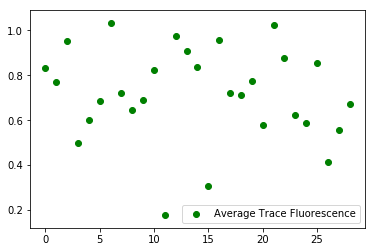

In [98]:
# give us an easy range to fit over
x = np.arange(len(avg_flors))
plt.scatter(x, avg_flors, color='g', label='Average Trace Fluorescence')
plt.legend(loc='best')

In [99]:
# do a multiple linear regression fitting for the constant parameter, Pon.
from scipy.optimize import curve_fit
popt_pon,_ = curve_fit(avg_flr_fn, x, ydata=avg_flors)   # return Pon
print("Average fitted P_on for trace package = " + str(popt_pon[0]))

Average fitted P_on for trace package = 0.6316583930992223


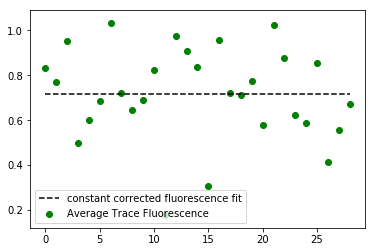

In [120]:
plt.scatter(x, avg_flors, color='g', label='Average Trace Fluorescence')
plt.plot(x, np.ones(len(x)) * avg_flr_fn(avg_flors, popt_pon),  '--', color='k', label='constant corrected fluorescence fit')

plt.legend(loc ='best')
plt.show()

In [101]:
# Do a quick bootstrap on the fluorescence averages to get an estimate range for the Pon parameter
x = np.arange(len(avg_flors))
ntrials = 1000                 # number of times we're going to run a fit

n_flor_avgs = len(avg_flors)    # size of our original dataset, our array of <F(t)> values

pon_list = []


sample_indx = np.arange(n_flor_avgs)   # index of our original dataset

# sample randomly with replacement from our set of <F(t)> values 

for i in range(ntrials):
    random_indx = np.random.choice(sample_indx, size=n_flor_avgs, replace=True)
    
    #print(len(random_indx))
    sample_set = np.asarray(avg_flors)[random_indx]    # select from our original dataset
    
    # now re-fit our data with a constant fit for the parameter Pon
    p_on,_ = curve_fit(avg_flr_fn, x, ydata=sample_set)
    
    pon_list.append(p_on)

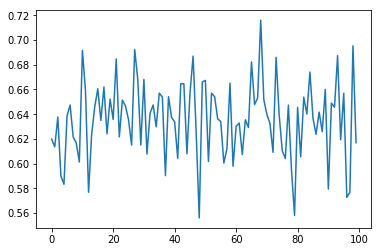

In [102]:
plt.plot(pon_list[::10])

In [103]:
from IPython import display
pon_array = np.asarray(pon_list) #* 100
low,med,hi = np.percentile(pon_array, [16, 50, 84], axis=0)
upper, lower = hi-med, med-low

disp_str1 = ""
for i,name in enumerate(['P_{on}']):
        fmt_str = '{name}={val:.4f}^{{+{plus:.4f}}}_{{-{minus:.4f}}}'
        disp_str1 += fmt_str.format(name=name, val=med[i], plus=upper[i], minus=lower[i])
        disp_str1 += r'\quad '

disp_str1 = "${}$".format(disp_str1)
display.Latex(data=disp_str1)


<IPython.core.display.Latex object>

In [104]:
# create a function that fits Pon and gives +/- 1sigma error bounds to be fed into the Autocorrelation fit.
def pon_fit():
    return pon_median, pon_upper, pon_lower

In [105]:
# now move on to fitting the autocorrelation function for the set of traces

In [106]:
""""
Autocorrelation function analysis for Two-State Model using Despond et al's (2016)
parameters:
    tPol: polII loading time
    k_elong:  MS2 GFP loop elongation rate along gene
    tPol:     polII loading time, assumed to load at every observation time
              ***NOTE: this is subject to change since there may exist a blocking time,
              or characteristic "traffic jam" time during polII loading ***
    sizePol:  "Footprint" or size of polII in basepairs, along gene
    
    k_gfp:    gfp loop agglomeration rate such that L(t) = k_gfp*t, L(t) !> maxloops
    maxloops: max number of gfp loops allowed in chain
    
    FITTING FOR:
    chartime: the characteristic decay timescale for autocorrelation. Tells us how
              similar the signal is to itself and can reveal burst characteristics
              chartime = 1 / (k_on + k_off)
              
    Pon:      Probability that system is in "ON" state.
    k_on:     given as 1/mu for exponential distribution of ON wait times
    k_off:    1/mu for exponential distribution of OFF wait times

    ***NOTE: k_on and k_off decoupled by Pon = k_on / (k_on + k_off)
    """


def autocorr(t, chartime):  # take in parameters and t (index of signal data array)
    # define all needed parameters #
    despondsfile = 'standalone/therightL.mat'
    tPol=6;                 # polII loading time
    k_elong=25;             # Elongation rate
    sizePol = tPol * ke     # Footprint, in basepairs, of polII
    
    tracelength = len(t)        # calculate from trace inputs
    
    # get the loop function
    loops = loopfn(despondsfile, tPol, k_elong, sizePol)
    
    # do the Pon fitting (once I've written the function)
    # pon,pon_upper,pon_lower = pon_fit()
    
    # FOR NOW:
    p_on = 0.63
    p_off = 1-p_on
    
    # compute normalization constant
    normfactor = normFactor(avg_flors)

    
    # write analytic autocorrelation function according to Desponds et al:    
    # chartime is defined as k_on + k_off
    
    delta = 1 - chartime    
   
       
    # write a for loop to do the double sums to compute connected correlation:
    sm0 = 0
    for i in range(len(loops)):
        for j in range(len(loops)):
            sm0 += p_on*p_off*(loops[i] * loops[j] * np.exp((delta-1)*np.abs(t - j + i)))
                
    connected_corr = np.asarray(sm0)    # the two-state connected correlation function
    
    N = len(t)         # CONSTANT trace length
    # r = len(connected_corr)
    
    
    # Add in the finite trace correction for the Ornstein-Uhlenbeck process    
    # perform the summations
    
    # initialize corrected lists
    corrected_full = []
    corrected = []
    Co = connected_corr[0]    # initial condition of connected correlation function
    
    # Now we're going to correct EVERY data point in the connected autocorrelation function
    for r in range(len(connected_corr)):
    
        sm1 = 0    
        for k in range(N):
            sm1 += 2*(N - k)*connected_corr[k]
    
        sm2 = 0   
        for j in range(r):
            sm2 += 2*(r-j)*connected_corr[j]

        sm3 = 0
        for m in range(N):
            sm3 += connected_corr[m] * (np.min(np.asarray([m+r, N])) - np.max(np.asarray([r, m])))

        # full correction
        corrected_full.append(((connected_corr[r] + 
                                    (1/N) *((1/N) - (2./(N-r))) * (N*Co + sm1)) + ((2/(N*(N-r))) * (r*Co + sm2 + sm3))))
        
    
    non_normed = (1/normfactor)*np.asarray(corrected_full)
    
    return (non_normed / non_normed[0])

In [107]:
# get our data's average autocorrelation function
dat = autoav[1:]   # take everything after the second data point (normalized there)
t = np.arange(len(dat))

In [108]:
len(dat)

24

In [109]:
t*6

array([  0,   6,  12,  18,  24,  30,  36,  42,  48,  54,  60,  66,  72,
        78,  84,  90,  96, 102, 108, 114, 120, 126, 132, 138])

In [110]:
from scipy.optimize import curve_fit
popt,pcov = curve_fit(autocorr, t, dat)

print("Characteristic timescale = ", popt[0])
print("t_polII_block            =  6 seconds")
print("k_on + k_off             = ", 1/popt[0])
print(pcov)

Characteristic timescale =  22.41356864924007
t_polII_block            =  6 seconds
k_on + k_off             =  0.04461583140326496
[[4.12737727e+14]]


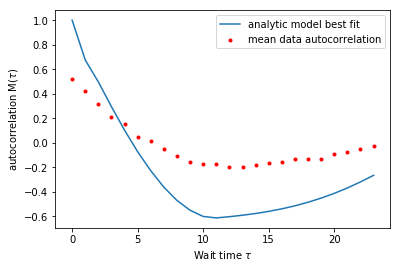

In [123]:
plt.plot(np.arange(len(autoav)-1), autocorr(t, popt[0]), label='analytic model best fit')
plt.scatter(np.arange(len(autoav)-1),dat, marker='.', color='r', label = 'mean data autocorrelation')   # show the mean of our original dataset in red
#plt.plot(t*6, dat)
plt.legend()
plt.xlabel(r'Wait time $\tau$')
plt.ylabel(r'autocorrelation M($\tau$)')
plt.show()